In [1]:
import pyekfmm as fmm
import numpy as np
import matplotlib.pyplot as plt

import pyekfmm as fmm
import numpy as np
import json

from func_short import compute_barycenter, extract_coordinates

from obspy.geodetics import gps2dist_azimuth
from obspy.clients.fdsn.client import Client
from obspy.core.utcdatetime import UTCDateTime

from scipy.interpolate import interpn
from scipy.interpolate import griddata

from scipy.interpolate import RegularGridInterpolator

from scipy.interpolate import interp2d

%matplotlib widget

In [2]:
def interpolate_3D_array(vel,depths,lons,lats,new_nz,new_nx,new_ny):
    points = (depths,lons,lats)
    new_depths = np.linspace(depths[0],depths[-1],new_nz).astype(np.float32)
    new_lons=  np.linspace(lons[0],lons[-1],new_nx).astype(np.float32)
    new_lats= np.linspace(lats[0],lats[-1],new_ny).astype(np.float32)
        
    interp =  RegularGridInterpolator(points=points,values=vel)
    
    new_points = np.zeros((new_nz*new_nx*new_ny,3), dtype=np.float32) #on fait auatnt de pts qu'on va avoir de points et on met 3 colonens pour pouvoir faire les coords des points !!
    zv, xv, yv = np.meshgrid(new_depths,new_lons,new_lats, indexing='ij') #fait un meshgrid pour avoir toutes les combinaisons d'index 
    zv, xv, yv = zv.flatten(), xv.flatten(), yv.flatten()
    new_points[:,0] = zv
    new_points[:,1] = xv
    new_points[:,2] = yv #on met alors tous les indexs dans la matricenew points 
    
    interpolated_vel = interp(new_points).astype(np.float32) #c'est bon on a calculé toutes les nouvelles valeurs, mais ça fait 1 ligne now, il faut donc reshape pour avoir sous forme d'une matrice
    
    interpolated_vel_goodshape = np.reshape(interpolated_vel,(new_nz,new_nx,new_ny)) # np.zeros((new_nz,new_nx,new_ny))
    print('modelled interpolated')
    return interpolated_vel_goodshape


### Import velocity model and interpolate it to have same for all dimensions

62 828 664
modelled interpolated
0.009836065573770493 0.009893850451338206 0.009834569956510776
0.01 0.01 0.01


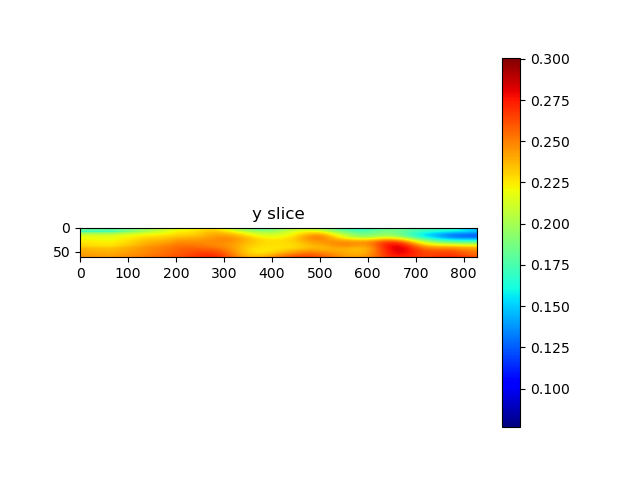

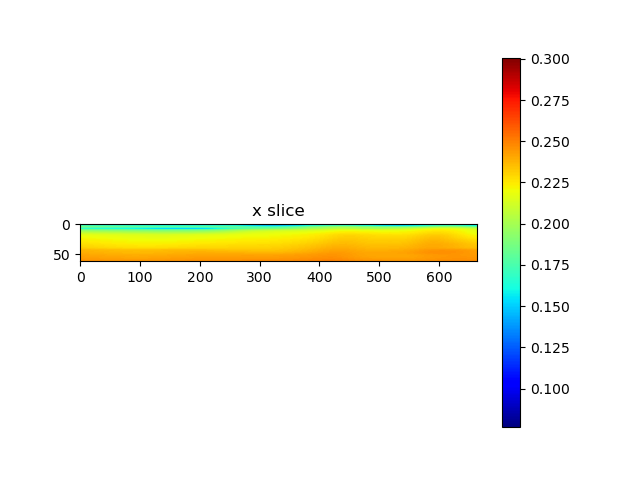

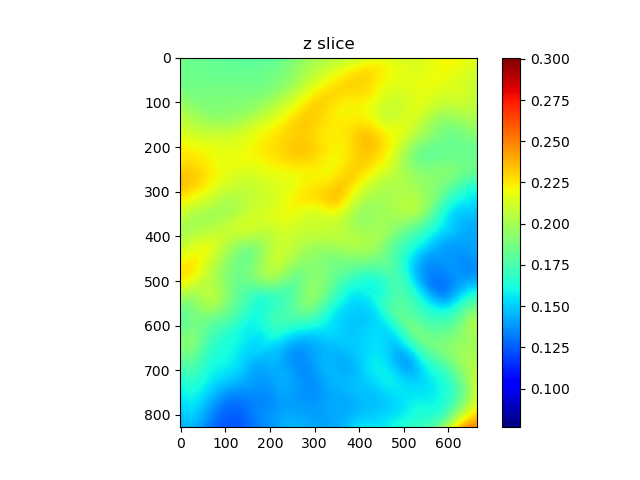

In [8]:
scale = 0.04 #scale 1 pour que les unitées soit des km
model_depth = 15000 #permet de choisir le modèle avec la profondeur max souhaitée ; utile si on veut éviter d'avoir de la PmP au delà de la distance  critique 
#on doit de nouveau trouver les coordonnées de notre source ans al fgiure + trouver les coordonnées de notre array 
#on devrait facilement pouvoir importer notre modèle de vitesse ici !!! il nous suffit de l'exporter depuis le notebook inteprolate histoire qu'on soit all good !!
wave_type = "vp" #on peut décidier soit de regarder la P soit de regarder la S ! yey !! 
metadata = json.load(open(f"{wave_type}_hslice/{wave_type}_hslice01.0_meta.json")) #
vel = np.load(f'{wave_type}_hslice/{wave_type}_3Dmodel_maxdepth_{model_depth}.npy') 
vel = np.float32(vel)# civnersion en float 32 sinon ça crash !!!
vel = vel/1000*scale #on passe les vitesses en km/s au lieu de m/s et pareil les units de la figure on les passe en km
nx = len(vel[0,:,0]) #trouve ancienne valeur de n 
ny = len(vel[0,0,:])
nz = len(vel[:,0,0])
#pas trivial de trouver le pas; il nous faut à présent calculer la distance entre des lons et lats pour connaitre le pas x et y  le z est connu par contre !
lon1, lat1 = float(metadata['lon1']), float(metadata['lat1']) #les coordonnées du premier point du profil  (à gauche du profil en xy)
lon2, lat2 = float(metadata['lon2']), float(metadata['lat2'])
lat_mean = (lat1+lat2)/2
lon_mean = (lon1+lon2)/2
dx = (gps2dist_azimuth(lat_mean,lon1,lat_mean,lon2)[0]/(nx-1))/1000*scale  #sur petit cercle, donc dépend de lat, on se met à lat moyenne pour être safe   /1000 pour avoir pas en km!!
dy = (gps2dist_azimuth(lat1,lon_mean,lat2,lon_mean)[0]/(ny-1))/1000*scale 
dy = np.round(dy,6) #doit arrondir sinon il fait un point en torp 
dz = ((model_depth)/(nz-1))/1000*scale #ça nous fait alors un pas qui est pas si dégueux en vrai 0.5... 
lons = np.arange(0,nx*dx,dx).astype(np.float32)
lats = np.arange(0,ny*dy,dy).astype(np.float32)
depths = np.arange(0,nz*dz,dz).astype(np.float32)


# ######################### A présent on peut interpoler le modèle de vitesse en lui fournissant de nouveaux nombre de pts ####
#l'objectif c'est d'avoir un nouveau pas spatial dans toutes les directions qui soit égal à 0.01 !!! il faut donc interpoler plus ou moins dans certaines directions pour 
#et on utilise un scaling down histoire de pas avoir à faire trop de points non plus! 
coeff_z = dz/0.01
coeff_x = dx/0.01
coeff_y = dy/0.01
# recalcule de façon à avoir le bon nombre de nz, nx et ny histoire de pouvoir faire un pas de 0.01 avec le modèle
nz = round(nz*coeff_z) 
nx = round(nx*coeff_x)
ny = round(ny*coeff_y)
print(nz,nx,ny)
vel = interpolate_3D_array(vel,depths,lons,lats,nz,nx,ny) #on a resmaplé le modèle de vitesse 

#on doit à présent recalculer le pas puisque l'on a resamplé!!
dx = (gps2dist_azimuth(lat_mean,lon1,lat_mean,lon2)[0]/(nx-1))/1000*scale  
dy = (gps2dist_azimuth(lat1,lon_mean,lat2,lon_mean)[0]/(ny-1))/1000*scale 
dz = ((model_depth)/(nz-1))/1000*scale #ça nous fait alors un pas qui est pas si dégueux en vrai 0.5... 
print(dz,dx,dy) #ici ça devrait être des trucs proches de 0.01 mais pas exactement; il faut donc arrondir à la 2ème décimale
dz,dx,dy = np.round(dz,2), np.round(dx,2), np.round(dy,2)
print(dz,dx,dy) #devrait être 0.01 du coup now
lons = np.arange(0,nx*dx,dx)
lats = np.arange(0,ny*dy,dy)
depths = np.arange(0,nz*dz,dz)

######################## PLOT LES SLICES POUR QC ###########"
vmin = vel.min()
vmax = vel.max()

fig = plt.subplots();
plt.imshow(vel[:,:,0], vmin=vmin, vmax=vmax);
plt.title('y slice')
plt.colorbar()
plt.jet();plt.show()

plt.figure();
plt.imshow(vel[:,0,:], vmin=vmin, vmax=vmax);
plt.title('x slice')
plt.colorbar()
plt.jet();plt.show()

plt.figure();
plt.imshow(vel[10,:,:], vmin=vmin, vmax=vmax);
plt.title('z slice')
plt.colorbar()
plt.jet();plt.show()

### Load source and receiver positions and compute their location on the model

(0.0, 6.63)

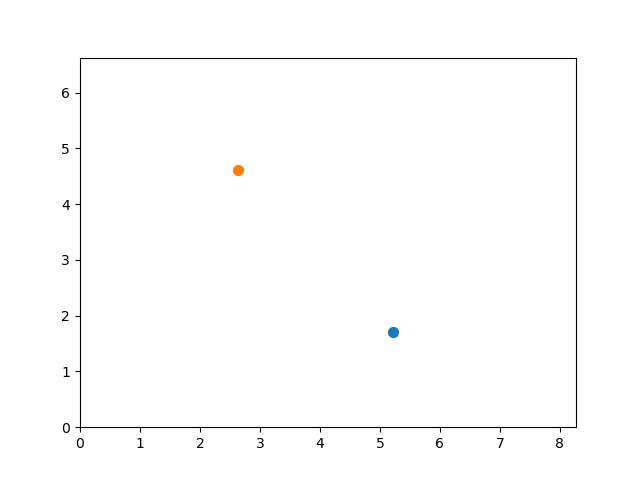

In [9]:
#############" c'est bon le modèle a maintenant la bonne t^te !!!
#on doit aussi calculer la position de la source à présent ! ! et on veut aussi connaitre la position du barycentre de l'array histoire de savoir la forme que prend le ray!!
station_file = 'stations_rm_nobad.txt'
lon_bary, lat_bary, height_bary = compute_barycenter(station_file)
inf_bary = gps2dist_azimuth(lat1,lon1,lat_bary,lon_bary)   #coordonnées du barycentre 
dist_bary = inf_bary[0]/1000*scale #conversion en km
az_bary = inf_bary[1]
x_barycenter = dist_bary*np.sin(np.deg2rad(az_bary))
y_barycenter = dist_bary*np.cos(np.deg2rad(az_bary))
z_barycenter = 0 
xli = np.arange(0,nx*dx,dx) #array avec les différentes valeur de x, permet de trouver l'indice le plus adapté 
yli = np.arange(0,ny*dy,dy)
x_bary_idx = np.argmin(np.abs(x_barycenter-xli))
y_bary_idx = np.argmin(np.abs(y_barycenter-yli))
plt.figure()
plt.scatter(x_barycenter, y_barycenter,s=50)
###### maintenant on trouve de quoi plot la  source 
eq = Client('NCEDC').get_events(starttime=UTCDateTime('2001-12-28 21:14:01.95')-2,endtime=UTCDateTime('2001-12-28 21:14:01.95')+2, minmagnitude=4.5, maxmagnitude=4.7) #Gonzales aka Tres Pinos
# eq = Client('NCEDC').get_events(starttime=UTCDateTime('2002-05-14 05:00:29')-2,endtime=UTCDateTime('2002-05-14 05:00:29')+2, minmagnitude=4.8, maxmagnitude=5.0) #Gilroy
# eq = Client('NCEDC').get_events(starttime=UTCDateTime('2002-05-24 17:44:01')-2,endtime=UTCDateTime('2002-05-24 17:44:01')+2, minmagnitude=3.7, maxmagnitude=3.9) #Soledad
# eq = Client('NCEDC').get_events(starttime=UTCDateTime('2001-11-07 07:59:34')-2,endtime=UTCDateTime('2001-11-07 07:59:34')+2, minmagnitude=2.8, maxmagnitude=3.0) #Simeon2
# eq = Client('NCEDC').get_events(starttime=UTCDateTime('2002-06-21 07:43:10')-2,endtime=UTCDateTime('2002-06-21 07:43:10')+2, minmagnitude=3.3, maxmagnitude=3.5) #central
# eq = Client('NCEDC').get_events(starttime=UTCDateTime('2002-01-16 15:29:20')-2,endtime=UTCDateTime('2002-01-16 15:29:20')+2, minmagnitude=3.2, maxmagnitude=3.3) #simeon
# eq = Client('NCEDC').get_events(starttime=UTCDateTime('2002-01-30 02:38:56')-2,endtime=UTCDateTime('2002-01-30 02:38:56')+2, minmagnitude=3.2, maxmagnitude=3.4)  #gonzales 2(purple)
eq_coords = (eq.events[0].origins[0].latitude, eq.events[0].origins[0].longitude)
inf_eq = gps2dist_azimuth(lat1,lon1,eq_coords[0],eq_coords[1])
dist_eq = inf_eq[0]/1000*scale #conversion km
az_eq = inf_eq[1]
x_eq = dist_eq*np.sin(np.deg2rad(az_eq))
y_eq = dist_eq*np.cos(np.deg2rad(az_eq))
z_eq = eq.events[0].origins[0].depth/1000*scale
plt.scatter(x_eq,y_eq, s=50) #on essaye de plotter la source 
plt.xlim(0,(nx-1)*dx)
plt.ylim(0,(ny-1)*dy)

### Makes the computation

In [10]:
### 3D computation
vxyz=np.swapaxes(np.swapaxes(vel,0,1),1,2);
t=fmm.eikonal(vxyz.flatten(order='F'),xyz=np.array([x_eq,y_eq,z_eq]),ax=[0,dx,nx],ay=[0,dy,ny],az=[0,dz,nz],order=2);
time=t.reshape(nx,ny,nz,order='F');#first axis (vertical) is x, second is z
tx,ty,tz = np.gradient(time)

### plot the result

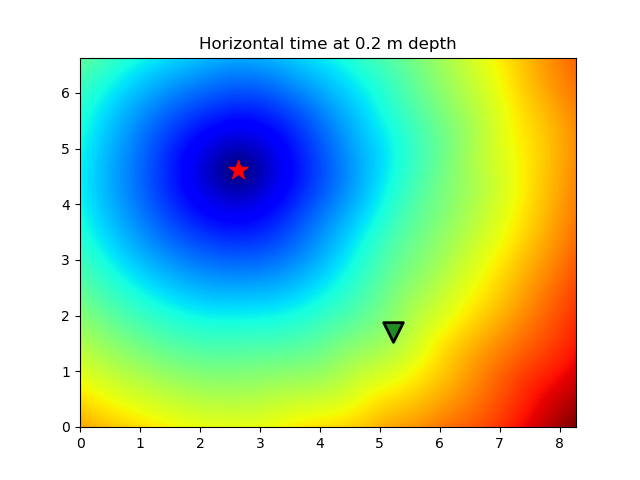

2.6361378750100184 4.615140602952483 0.263
171 523 1
171 523 1


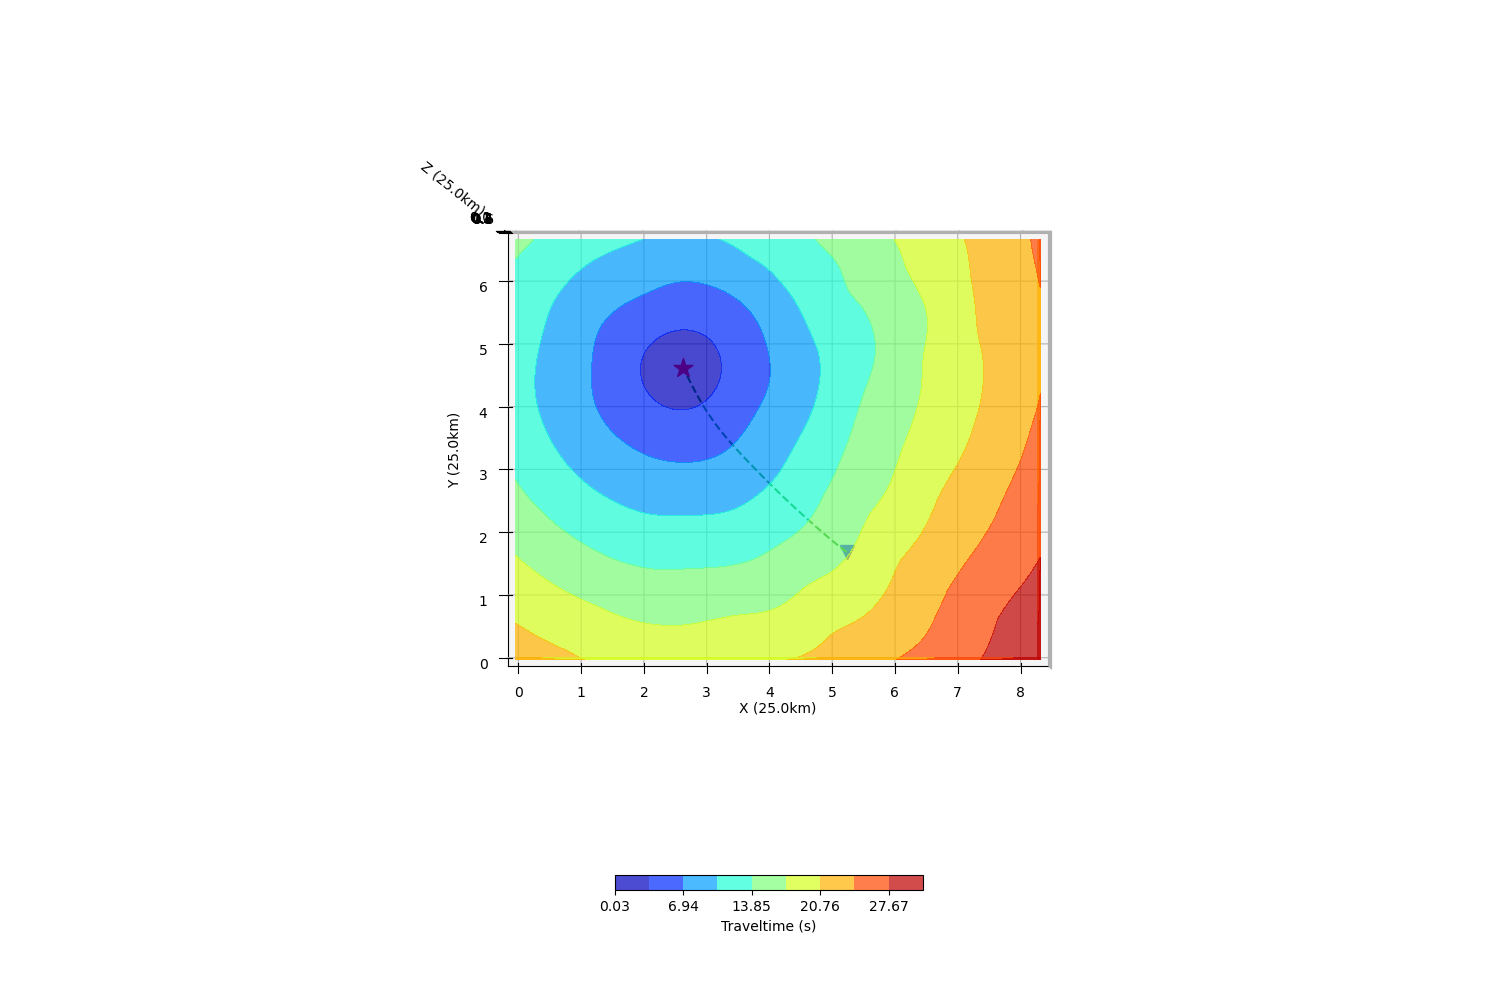

In [11]:
plt.close('all')
##############" time to plot stuff ##### 
idx = 20
plt.figure();
plt.pcolormesh(lons,lats,time[:,:,idx].T);
plt.scatter(x_eq,y_eq,marker='*',color='red',s=200)
plt.scatter(x_barycenter,y_barycenter,color='forestgreen',marker='v',s=200,edgecolors='black',linewidths=2)
plt.title(f'Horizontal time at {idx*dz} m depth')
plt.jet();plt.show()

############################ PLOTTING IN 3D  
# Define dimensions
X, Y, Z = np.meshgrid(np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz)

# Specify the 3D data
data=np.transpose(time,(1,0,2)); ## data requires [y,x,z] so tranpose the first and second axis
# data=np.transpose(time,(2,1,0)); #[z,x,y] -> [y,x,z]


kw = {
    'vmin': data.min(),
    'vmax': data.max(),
    'levels': np.linspace(data.min(), data.max(), 10),
}


# Create a figure with 3D ax
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(projection='3d')
plt.jet()
# Plot contour surfaces
_ = ax.contourf(
    X[:, :, -1], Y[:, :, -1], data[:, :, 0],
    zdir='z', offset=0, alpha=0.7, **kw
)
_ = ax.contourf(
    X[0, :, :], data[0, :, :], Z[0, :, :],
    zdir='y', offset=0, alpha=0.7, **kw
)
C = ax.contourf(
    data[:, -1, :], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), alpha=0.7, **kw
)
# --

# Set limits of the plot from coord limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# Set labels and zticks
ax.set(
    xlabel=f'X ({1/scale}km)',
    ylabel=f'Y ({1/scale}km)',
    zlabel=f'Z ({1/scale}km)',
)

# Set zoom and angle view
ax.view_init(90, -90, 0)
ax.set_box_aspect(None, zoom=0.9)
ax.set_aspect('equal')

# Colorbar
cbar=fig.colorbar(C, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1, format= "%.2f", label='Traveltime (s)')
cbar.ax.locator_params(nbins=5)

print(x_eq,y_eq,z_eq)
plt.gca().scatter(x_eq,y_eq,z_eq,s=200,marker='*',color='r')

# plt.savefig('test_1_vgrad_ray3d.png',format='png',dpi=300,bbox_inches='tight', pad_inches=0)

print(y_bary_idx, x_bary_idx, 1)
paths,nrays=fmm.stream3d(-ty,-tx, -tz,y_bary_idx,x_bary_idx, 1, step=0.5, maxvert=100000)
plt.plot((x_bary_idx-1)*dx,(y_bary_idx-1)*dy,z_barycenter,'vb',markersize=10);
## plot rays
plt.plot((paths[1,:]-1)*dy,(paths[0,:]-1)*dx,(paths[2,:]-1)*dz,'g--',markersize=20);



plt.gca().invert_zaxis()
plt.show()


# plt.savefig('test_pyekfmm_fig4.png',format='png',dpi=300,bbox_inches='tight', pad_inches=0)
# plt.savefig('test_pyekfmm_fig4.pdf',format='pdf',dpi=300,bbox_inches='tight', pad_inches=0)




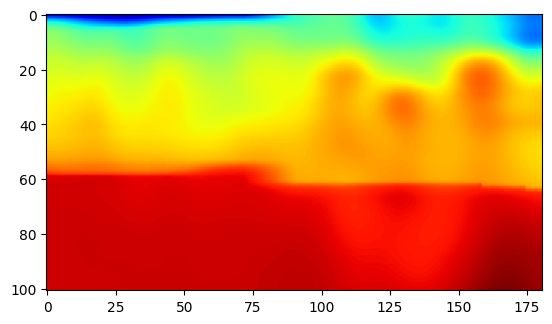

In [3]:
### 1D try !!! 
#on devrait facilement pouvoir importer notre modèle de vitesse ici !!! il nous suffit de l'exporter depuis le notebook inteprolate histoire qu'on soit all good !!
metadata = json.load(open(f"vp_gonzales_meta.json"))
vel = np.load('vp_gonzales_crosssection.npy').T
vel = vel[::-1,:] #on corrige la réorganisation effectuée dans le code original
nz = len(vel[:,0])
nx = len(vel[0,:])
dx = int(metadata['horizontal_spacing'])
dz = int(metadata['vertical_spacing'])
plt.imshow(vel);plt.jet();plt.show()
#############" c'est bon le modèle a maintenant la bonne t^te !!!
#on doit aussi calculer la position de la source à présent ! ! et on veut aussi connaitre la position du barycentre de l'array histoire de savoir la forme que prend le ray!!
lon1, lat1 = float(metadata['lon1']), float(metadata['lat1']) #les coordonnées du premier point du profil  (à gauche du profil en xy)
station_file = 'stations_rm_nobad.txt'
lon_bary, lat_bary, height_bary = compute_barycenter(station_file)
x_barycenter = gps2dist_azimuth(lat1,lon1,lat_bary,lon_bary)[0]   #coordonnées du barycentre 
eq = Client('NCEDC').get_events(starttime=UTCDateTime('2001-12-28 21:14:01.95')-2,endtime=UTCDateTime('2001-12-28 21:14:01.95')+2, minmagnitude=4.5, maxmagnitude=4.7)
eq_coords = (eq.events[0].origins[0].latitude, eq.events[0].origins[0].longitude)
z_eq = eq.events[0].origins[0].depth
x_eq = gps2dist_azimuth(lat1,lon1,eq_coords[0],eq_coords[1])[0]

#on doit convertir le x_barycenter en idx du plot pour le ray
xli = np.arange(0,nx*dx,dx)
x_bary_idx = np.argmin(np.abs(x_barycenter-xli))
####o

(18281,)


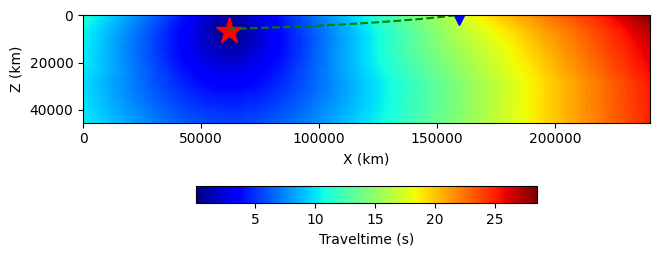

In [5]:
t=fmm.eikonal(vel.transpose().flatten(order='F'),xyz=np.array([x_eq,0,z_eq]),ax=[0,dx,nx],ay=[0,0.01,1],az=[0,dz,nz],order=2);
time=t.reshape(nx,nz,order='F');#first axis (vertical) is x, second is z
time=time.transpose(); #z,x

# tz=np.gradient(time,axis=1);
# tx=np.gradient(time,axis=0);
# # or
tz,tx = np.gradient(time)




# fig = plt.figure(figsize=(16, 8))
fig, ax = plt.subplots()
fig.tight_layout();

plt.imshow(time,cmap=plt.cm.jet, interpolation='none', extent=[0,nx*dx,nz*dz,0]); #transpose so that first axis is z, second is x

plt.plot(x_eq,z_eq,'*r',markersize=20);
plt.xlabel('X (km)');plt.ylabel('Z (km)');
plt.jet()
plt.colorbar(orientation='horizontal',shrink=0.6,label='Traveltime (s)');


#à réactiver pour voir les rays !!!

paths,nrays=fmm.stream2d(-tx,-tz, x_bary_idx, 1, step=0.1, maxvert=100000)
plt.plot(x_barycenter,0,'vb',markersize=15);
## plot rays
plt.plot((paths[0,:]-1)*dx,(paths[1,:]-1)*dz,'g--',markersize=20);

#c'est bon on est fin prêt à faire du ray tracing en 3D à présent !!! ça devrait se faire très facilement à priori !!! let's gooo 





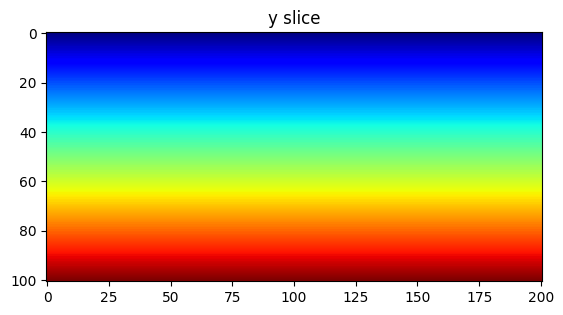

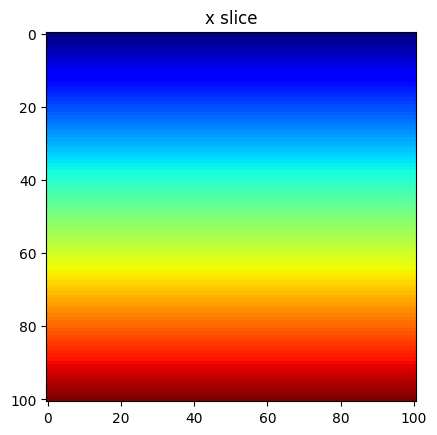

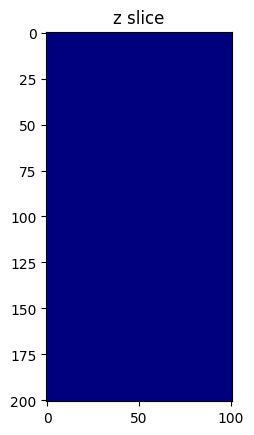

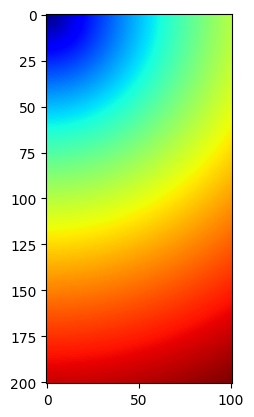

101.0 101.0 101.0
Before trim (3, 1326)
After trim (3, 1327)


In [37]:



v1=1;
v2=3;

nz=101;
nx=201;
ny=101;
dx=0.01;
dz=0.01;
dy=0.01;


# vel=3.0*np.ones([101*101,1],dtype='float32'); #velocity axis must be x,y,z respectively
v=np.linspace(v1,v2,nz);
v=np.expand_dims(v,1);
h=np.ones([1,nx])
vel=np.multiply(v,h,dtype='float32'); #z,x

vel3d=np.zeros([nz,nx,ny],dtype='float32');
for ii in range(ny):
	vel3d[:,:,ii]=vel
    
    

plt.figure();
plt.imshow(vel3d[:,:,0]);
plt.title('y slice')
plt.jet();plt.show()


plt.figure();
plt.imshow(vel3d[:,0,:]);
plt.title('x slice')
plt.jet();plt.show()



plt.figure();
plt.imshow(vel3d[0,:,:]);
plt.title('z slice')
plt.jet();plt.show()


vxyz=np.swapaxes(np.swapaxes(vel3d,0,1),1,2);
t=fmm.eikonal(vxyz.flatten(order='F'),xyz=np.array([0,0,0]),ax=[0,dx,nx],ay=[0,dy,ny],az=[0,dz,nz],order=2);
time=t.reshape(nx,ny,nz,order='F');#first axis (vertical) is x, second is z
# time=np.swapaxes(np.swapaxes(time,1,2),0,1);

plt.figure();
plt.imshow(time[:,:,0]);
plt.jet();plt.show()

# tz=np.gradient(time,axis=1);
# tx=np.gradient(time,axis=0);
# # or
# tz,tx,ty = np.gradient(time)

tx,ty,tz = np.gradient(time)

receiverx=101.0
receivery=101.0
receiverz=101.0
paths,nrays=fmm.stream3d(-tx,-ty, -tz, receiverx, receivery, receiverz, step=0.1, maxvert=10000)
print('Before trim',paths.shape)
## trim the rays and add the source point
paths=fmm.trimrays(paths,start_points=np.array([1,1,1]),T=0.5)
print('After trim',paths.shape)